# Parameters

In [1]:
PREFIX = "TEST_10sec"

# Environment

In [2]:
from utils.noise_utils import (
    get_sounds,
    get_notes,
    sound_note_contains,
    get_data_loaders,
)
from utils.plot import plot_sounds
from lightning.pytorch import Trainer
from torchaudio.transforms import Spectrogram
from torch import device as torch_device, cuda, __version__

# from utils.noise_arquitecture import NoiseClassifier

__version__

'2.0.0'

# Import data

In [3]:
sounds, names = get_sounds(
    records_dir=f"data/tensors/{PREFIX}_resized_records.pt",
    names_dir=f"data/tensors/{PREFIX}_records_names.xz",
)

sound_notes = get_notes(
    csv_dir="data/physionet.org/files/ephnogram/1.0.0/ECGPCGSpreadsheet.csv",
    id_col="Record Name",
    notes_col="PCG Notes",
    names=names,
)
labels = sound_note_contains(sound_notes, contains="Good")

sounds[0], names[0], labels[0]

(tensor([[-0.0064, -0.0044, -0.0049,  ...,  0.0147,  0.0142,  0.0137]]),
 'ECGPCG0016',
 tensor([1.]))

# Plot records

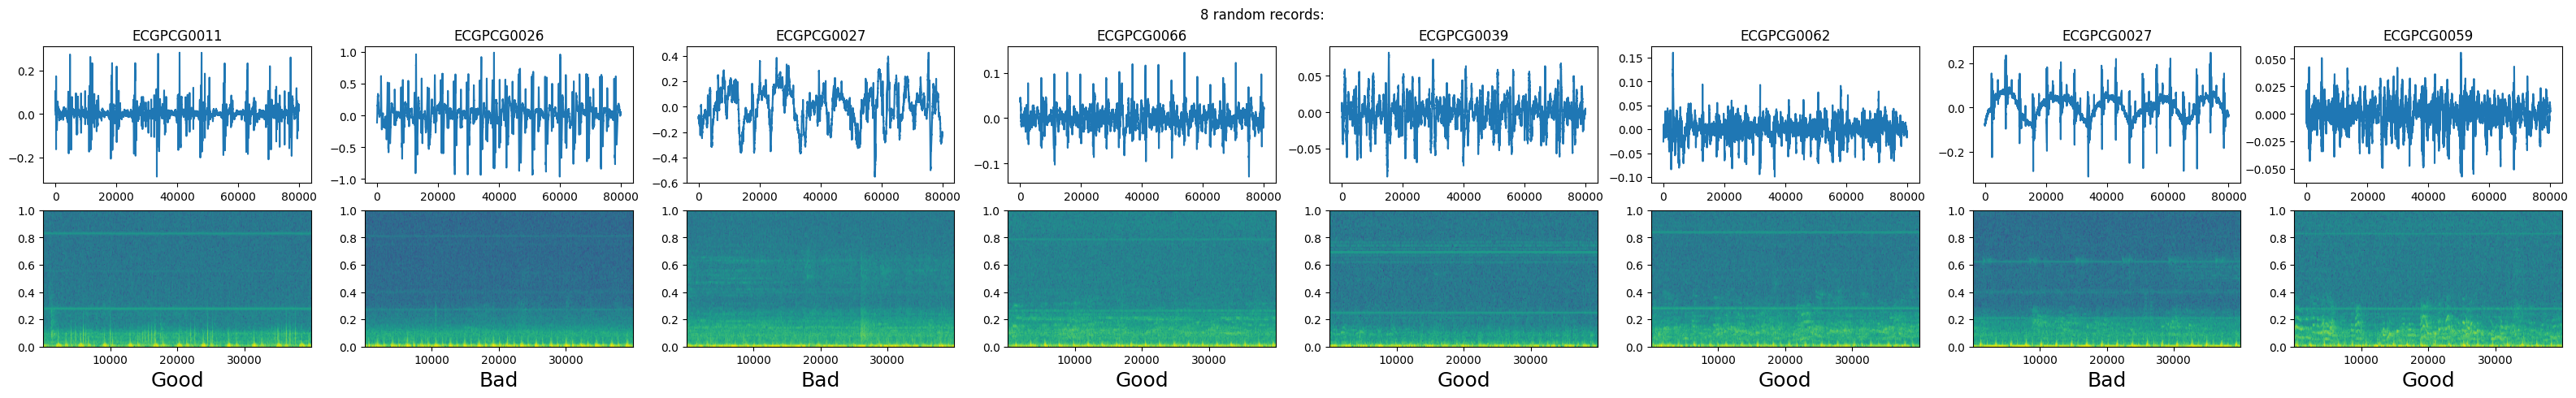

In [5]:
plot_sounds(
    sounds,
    names,
    labels,
    n=8,
    spectrogram=True,
    shuffle=True,
)

# Train and test

In [6]:
train, test = get_data_loaders(
    sounds,
    labels,
    batch_size=64,
    num_workers=1,
    transform=Spectrogram(),
)

train

# Model Architecture

In [19]:
from torch import flatten
from torch.optim import Adam
from collections import OrderedDict
from lightning.pytorch import LightningModule
from torch.nn.functional import binary_cross_entropy
from torch.nn import (
    Sequential,
    ReLU,
    LazyConv2d,
    MaxPool2d,
    LazyLinear,
    Sigmoid,
    BCEWithLogitsLoss,
)


class NoiseClassifier(LightningModule):
    def __init__(self):
        super().__init__()

        self.conv_net = Sequential(
            OrderedDict(
                [
                    ("C1", LazyConv2d(32, kernel_size=(5, 5))),
                    ("Relu1", ReLU()),
                    ("S2", MaxPool2d(kernel_size=(2, 2), stride=2)),
                    ("C3", LazyConv2d(64, kernel_size=(5, 5))),
                    ("Relu3", ReLU()),
                    ("S4", MaxPool2d(kernel_size=(2, 2), stride=2)),
                    ("C5", LazyConv2d(128, kernel_size=(5, 5))),
                    ("Relu5", ReLU()),
                    ("S5", MaxPool2d(kernel_size=(2, 2), stride=2)),
                    ("C6", LazyConv2d(256, kernel_size=(5, 5))),
                    ("Relu6", ReLU()),
                ]
            )
        )

        self.fully_connected = Sequential(
            OrderedDict(
                [
                    ("F7", LazyLinear(150)),
                    ("Relu7", ReLU()),
                    ("F8", LazyLinear(100)),
                    ("Relu8", ReLU()),
                    ("F9", LazyLinear(50)),
                    ("Relu9", ReLU()),
                    ("F10", LazyLinear(1)),
                    ("Sigmoid", Sigmoid()),
                ]
            )
        )

    def forward(self, input):
        output = self.conv_net(input)
        output = flatten(output, start_dim=1)
        output = self.fully_connected(output)
        return output

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)

        accuracy = binary_cross_entropy(y_hat, y)
        self.log("train_accuracy", accuracy)

        loss_fn = BCEWithLogitsLoss()
        loss = loss_fn(y_hat, y)
        self.log("train_loss", loss)

        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)

        accuracy = binary_cross_entropy(y_hat, y)
        self.log("val_accuracy", accuracy)

        loss_fn = BCEWithLogitsLoss()
        loss = loss_fn(y_hat, y)
        self.log("val_loss", loss)

        return loss

    def configure_optimizers(self):
        optimizer = Adam(self.parameters(), lr=1e-3)
        return optimizer

In [20]:
noise_classifier = NoiseClassifier()
device = torch_device("cuda" if cuda.is_available() else "cpu")
noise_classifier = noise_classifier.to(device)

# Train

In [21]:
noise_classifier

NoiseClassifier(
  (conv_net): Sequential(
    (C1): LazyConv2d(0, 32, kernel_size=(5, 5), stride=(1, 1))
    (Relu1): ReLU()
    (S2): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
    (C3): LazyConv2d(0, 64, kernel_size=(5, 5), stride=(1, 1))
    (Relu3): ReLU()
    (S4): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
    (C5): LazyConv2d(0, 128, kernel_size=(5, 5), stride=(1, 1))
    (Relu5): ReLU()
    (S5): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
    (C6): LazyConv2d(0, 256, kernel_size=(5, 5), stride=(1, 1))
    (Relu6): ReLU()
  )
  (fully_connected): Sequential(
    (F7): LazyLinear(in_features=0, out_features=150, bias=True)
    (Relu7): ReLU()
    (F8): LazyLinear(in_features=0, out_features=100, bias=True)
    (Relu8): ReLU()
    (F9): LazyLinear(in_features=0, out_features=50, bias=True)
    (Relu9): ReLU()
    (F10): LazyLinear(in_features=0, out_features=1, bias=True

In [22]:
trainer = Trainer(limit_train_batches=100, max_epochs=10, log_every_n_steps=30)
trainer.fit(model=noise_classifier, train_dataloaders=train, val_dataloaders=test)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name            | Type       | Params
-----------------------------------------------
0 | conv_net        | Sequential | 0     
1 | fully_connected | Sequential | 0     
-----------------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)


Epoch 9: 100%|██████████| 39/39 [00:30<00:00,  1.28it/s, v_num=3]          

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 39/39 [00:30<00:00,  1.27it/s, v_num=3]
